In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import nltk

from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import classification_report

In [2]:
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)
pd.set_option('display.max_colwidth', None)
pd.set_option('display.width', None)

## Multinomial naive bayes

In [3]:
df = pd.read_csv("data/prepared_data.csv")
# df = df[df['LabelType'] == "Sentiment"]
# df = df.dropna(subset=['cleaned_text'])

In [ ]:
df

### 1. Prepare data

In [39]:
reviews = df['cleaned_text']
# reviews = reviews.dropna()
y = df['LabelMapped']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

### 2. Vectorize text

In [40]:
vectorizer = TfidfVectorizer()
X_train_tfidf = vectorizer.fit_transform(X_train)
X_test_tfidf = vectorizer.transform(X_test)

In [41]:
# If we want to see the vectorization
X_array = X_train_tfidf.toarray()
feature_names = vectorizer.get_feature_names_out()
print("Feature Names (Vocabulary):")
print(feature_names)
print("\nTF-IDF Matrix:")
print(X_array)

Feature Names (Vocabulary):
['aa' 'aaa' 'aaaa' ... 'zzzz' 'zzzzzzzz' 'zzzzzzzzzz']

TF-IDF Matrix:
[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]


## 3. Train a model 

In [42]:
model = MultinomialNB()
model.fit(X_train_tfidf, y_train)

MultinomialNB()

### 4. Evaluate the model

In [43]:
y_pred = model.predict(X_test_tfidf)
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

          -1       0.50      0.00      0.00      1552
           0       0.58      0.78      0.66      4532
           1       0.65      0.65      0.65      3933

    accuracy                           0.60     10017
   macro avg       0.58      0.47      0.44     10017
weighted avg       0.59      0.60      0.55     10017



           Predicted -1  Predicted 0  Predicted 1
Actual -1             1         1196          355
Actual 0              1         3516         1015
Actual 1              0         1390         2543


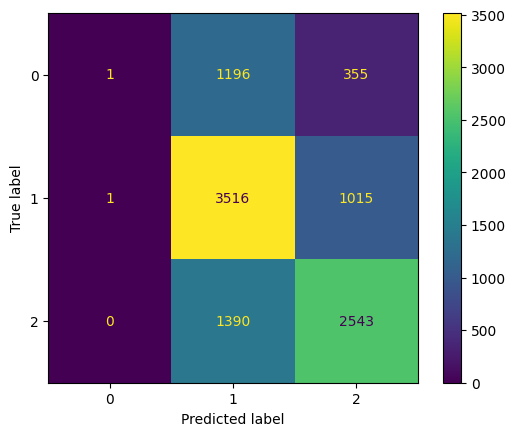

In [44]:
# Confusion matrix
cm = confusion_matrix(y_test, y_pred)
cm_df = pd.DataFrame(cm, index=['Actual -1', 'Actual 0', 'Actual 1'], columns=['Predicted -1', 'Predicted 0', 'Predicted 1'])
print(cm_df)

ConfusionMatrixDisplay(confusion_matrix=cm).plot()
plt.show()